In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


### Load Dataset

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 98% 326M/331M [00:05<00:00, 43.4MB/s]
100% 331M/331M [00:05<00:00, 64.3MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

### Import Librraies

In [4]:
import os
import numpy as np
import pandas as pd

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from pathlib import Path
from tensorflow.keras.models import Model

### Loading Data and Pre-processing

In [6]:
# Load UTKFace dataset
path = Path("/content/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))
print(len(filenames))
print(filenames[:3])

23708
['26_1_1_20170117200205236.jpg.chip.jpg', '26_1_1_20170113001606417.jpg.chip.jpg', '23_1_0_20170103233631243.jpg.chip.jpg']


### From Unstructured data to Structured data

In [7]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, race_labels, image_path = [], [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    race_labels.append(temp[2])

In [8]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_path, age_labels, gender_labels, race_labels

In [9]:
# Remove outliers
df = df[df['race'].isin(['0', '1', '2', '3', '4'])]
gender_dict = {0: "Male", 1: "Female"}
race_dict = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}

In [10]:
df['gender'] = df['gender'].astype('int32')
df['age'] = df['age'].astype('int32')
df['race'] = df['race'].astype('int32')

In [11]:
print(df.dtypes)

image     object
age        int32
gender     int32
race       int32
dtype: object


In [12]:
df.head()

image  age  gender  race
0  58_0_0_20170105173557845.jpg.chip.jpg   58       0     0
1  52_0_3_20170119205641007.jpg.chip.jpg   52       0     3
2  35_1_1_20170112193019582.jpg.chip.jpg   35       1     1
3  40_0_1_20170113161517669.jpg.chip.jpg   40       0     1
4  22_1_0_20170117141131710.jpg.chip.jpg   22       1     0

### Plotting Images

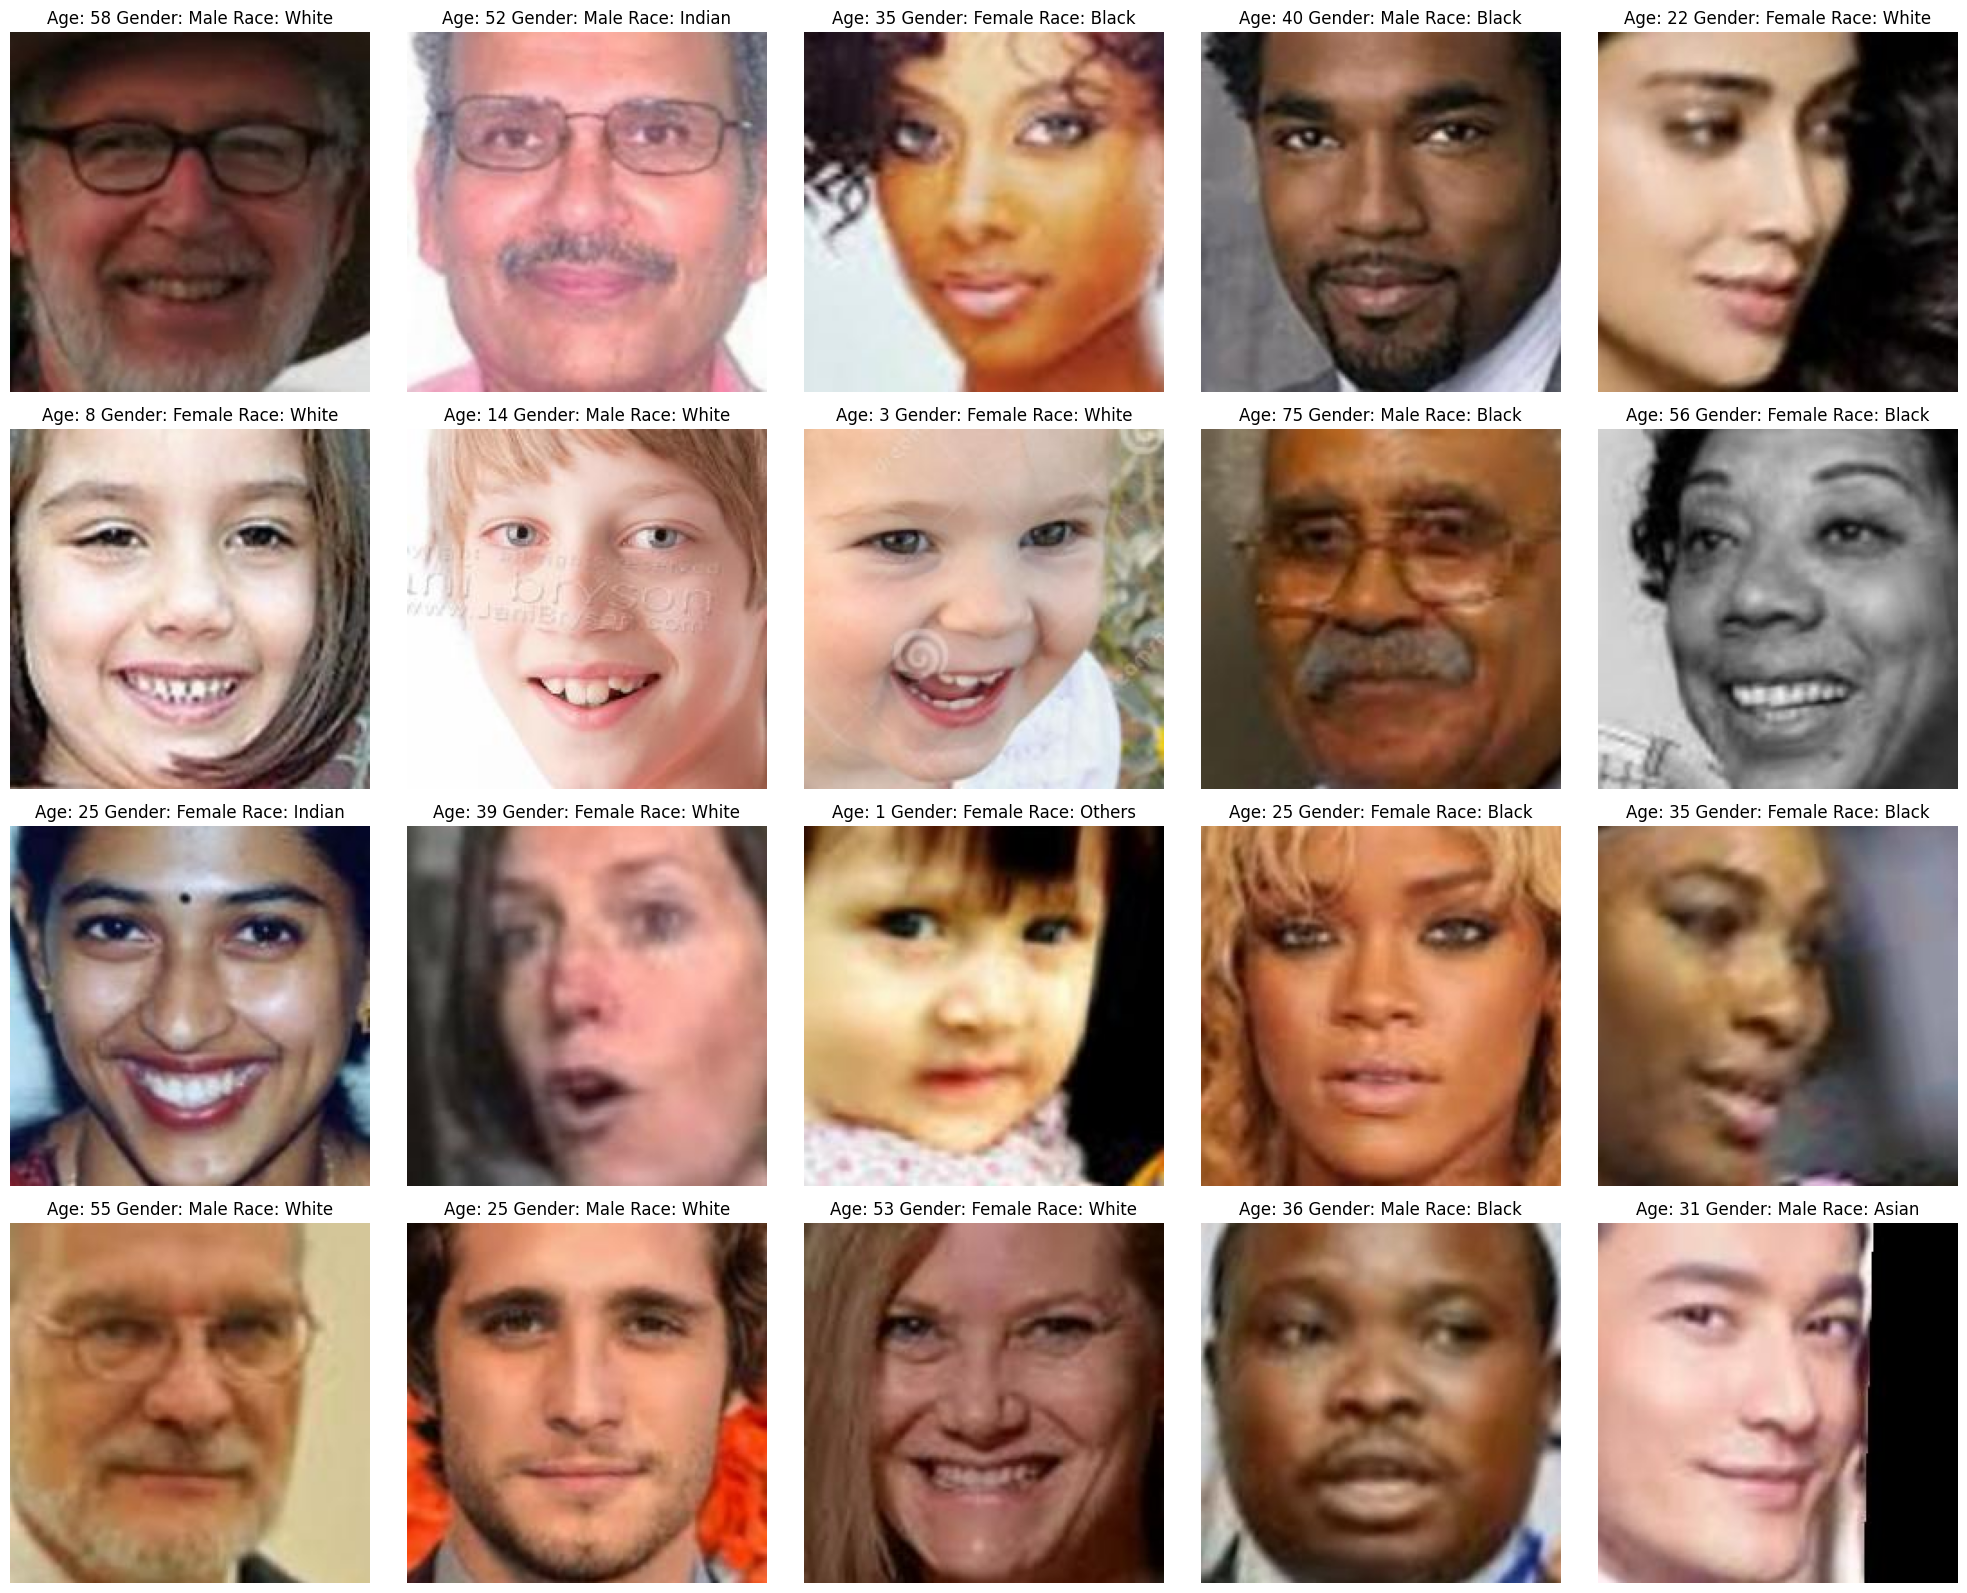

In [23]:
from keras.preprocessing.image import load_img
import numpy as np
import matplotlib.pyplot as plt
import os

files = df.iloc[0:20]
plt.figure(figsize=(20, 20))

for index, file, age, gender, race in files.itertuples():
    # Joining the path directly without any condition
    file_path = os.path.join("/content/UTKFace", file)

    # Load and display image
    img = load_img(file_path)
    img = np.array(img)
    plt.subplot(5, 5, index + 1)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender] } Race: {race_dict[race]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Split into test and train

In [26]:
train_df = df.sample(frac=1, random_state=0).iloc[:20000]  # First 20000 images for training
test_df = df.sample(frac=1, random_state=0).iloc[20000:]   # Remaining images for testing

### Data Augmentation

In [27]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path,
    x_col='image',
    y_col=['age', 'gender', 'race'],
    target_size=(200, 200),
    class_mode=None,  # Use None for multiple outputs
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path,
    x_col='image',
    y_col=['age', 'gender', 'race'],
    target_size=(200, 200),
    class_mode=None,  # Use None for multiple outputs
    batch_size=32
)

Found 20000 validated image filenames.
Found 3705 validated image filenames.


### Create Model

In [28]:
from tensorflow.keras.applications import ResNet50

# Load ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Freeze the base ResNet50 model
resnet.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [29]:
# Define new top layers
output = resnet.output
flatten = Flatten()(output)

# Dense layers
dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512, activation='relu')(dense1)

# Output layers
output1 = Dense(1, activation='linear', name='age')(dense2)  # Age regression
output2 = Dense(1, activation='sigmoid', name='gender')(dense2)  # Gender classification
output3 = Dense(5, activation='softmax', name='race')(dense2)  # Race classification

In [30]:
# Define the model
model = Model(inputs=resnet.input, outputs=[output1, output2, output3])
model.compile(
    optimizer='adam',
    loss={
        'age': 'mean_squared_error',
        'gender': 'binary_crossentropy',
        'race': 'categorical_crossentropy'
    },
    metrics={
        'age': 'mae',
        'gender': 'accuracy',
        'race': 'accuracy'
    },
    loss_weights={
        'age': 1,
        'gender': 1,
        'race': 1
    }
)

### Data Generators

In [31]:
def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
    batch_df = self.dataframe.iloc[indexes]

    X, y = self.__data_generation(batch_df)  # Unpacking into X and y (dictionary)
    return X, y

In [32]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

class MultiOutputDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, directory, batch_size=32, target_size=(200, 200), num_classes_race=5, shuffle=True):
        self.dataframe = dataframe
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_classes_race = num_classes_race
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataframe))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[indexes]

        X, y_age, y_gender, y_race = self.__data_generation(batch_df)
        return X, {'age': y_age, 'gender': y_gender, 'race': y_race}

    def __data_generation(self, batch_df):
        X = np.empty((self.batch_size, *self.target_size, 3))
        y_age = np.empty((self.batch_size, 1))
        y_gender = np.empty((self.batch_size, 1))
        y_race = np.empty((self.batch_size, self.num_classes_race))

        for i, (_, row) in enumerate(batch_df.iterrows()):
            image_path = os.path.join(self.directory, row['image'])
            image = load_img(image_path, target_size=self.target_size)
            image_array = img_to_array(image) / 255.0
            X[i,] = image_array

            y_age[i] = row['age']
            y_gender[i] = row['gender']
            y_race[i] = to_categorical(int(row['race']), num_classes=self.num_classes_race)

        return X, y_age, y_gender, y_race

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [33]:
# Create train and test generators
train_generator = MultiOutputDataGenerator(train_df, path, batch_size=32)
test_generator = MultiOutputDataGenerator(test_df, path, batch_size=32)

# Test the generator
try:
    for X_batch, y_batch in train_generator:
        print("X_batch shape:", X_batch.shape)  # Should be (batch_size, 200, 200, 3)
        print("y_batch['age'] shape:", y_batch['age'].shape)  # Should be (batch_size, 1)
        print("y_batch['gender'] shape:", y_batch['gender'].shape)  # Should be (batch_size, 1)
        print("y_batch['race'] shape:", y_batch['race'].shape)  # Should be (batch_size, 5)
        break
except Exception as e:
    print("Error in generator:", e)

X_batch shape: (32, 200, 200, 3)
y_batch['age'] shape: (32, 1)
y_batch['gender'] shape: (32, 1)
y_batch['race'] shape: (32, 5)


### Compile the model

In [39]:
model.compile(
    optimizer='adam',
    loss={
        'age': 'mean_squared_error',
        'gender': 'binary_crossentropy',
        'race': 'categorical_crossentropy'
    },
    metrics={
        'age': 'mae',
        'gender': 'accuracy',
        'race': 'accuracy'
    },
    loss_weights={
        'age': float(1),  # Convert to float
        'gender': float(99),  # Convert to float
        'race': float(1)  # Convert to float
    }
)

### Train the model

In [40]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 104s 134ms/step - age_mae: 15.8886 - gender_accuracy: 0.5218 - loss: 600.7843 - race_accuracy: 0.3129 - val_age_mae: 14.0152 - val_gender_accuracy: 0.5462 - val_loss: 378.2206 - val_race_accuracy: 0.4370
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 111ms/step - age_mae: 13.7574 - gender_accuracy: 0.6075 - loss: 377.2721 - race_accuracy: 0.4012 - val_age_mae: 12.2295 - val_gender_accuracy: 0.5562 - val_loss: 317.1320 - val_race_accuracy: 0.4408
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 110ms/step - age_mae: 12.4737 - gender_accuracy: 0.6817 - loss: 315.5613 - race_accuracy: 0.4062 - val_age_mae: 12.1144 - val_gender_accuracy: 0.7375 - val_loss: 303.0089 - val_race_accuracy: 0.4372
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - age_mae: 11.9132 - gender_accuracy: 0.6971 - loss: 294.0255 - race_accuracy: 0.4271 - val_age_mae: 12.5689 - val_gender_accuracy: 0.6696 - val_loss: 303.0655 - val_race_accuracy: 0.4397
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━

### Model plot

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.853374 to fit



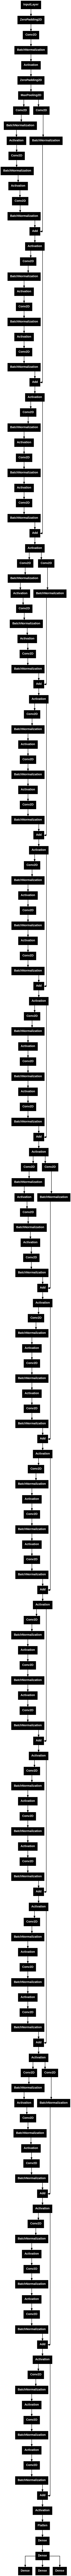

In [ ]:
from keras.utils import plot_model
plot_model(model)

### Prediction

In [ ]:
# Prediction step
def predict_age_gender_race(image_path):
    image = load_img(image_path, target_size=(200, 200))
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0) / 255.0
    predictions = model.predict(image_array)
    age, gender, race = predictions
    return age, gender, race

# Example prediction
example_image_path = "/content/test-image.png"
age, gender, race = predict_age_gender_race(example_image_path)
print(f"Predicted age: {age}")
print(f"Predicted gender: {'Male' if gender > 0.01 else 'Female'}")
print(f"Predicted race: {race_dict[np.argmax(race)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted age: [[57.524757]]
Predicted gender: Male
Predicted race: White


### Visualizing Loss

In [43]:
print(history.history.keys())


dict_keys(['age_mae', 'gender_accuracy', 'loss', 'race_accuracy', 'val_age_mae', 'val_gender_accuracy', 'val_loss', 'val_race_accuracy'])


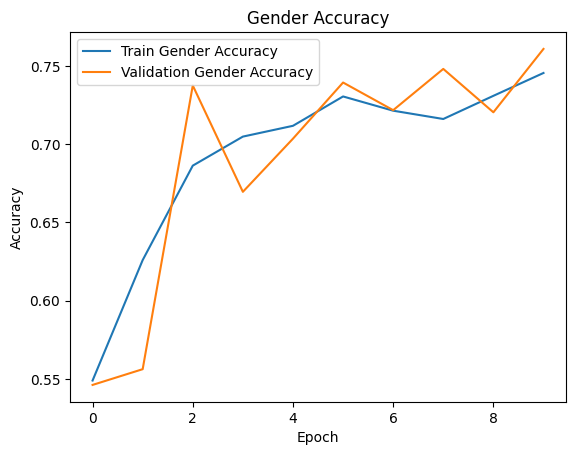

In [44]:
# Plot Gender Accuracy
plt.plot(history.history['gender_accuracy'], label='Train Gender Accuracy')
plt.plot(history.history['val_gender_accuracy'], label='Validation Gender Accuracy')
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

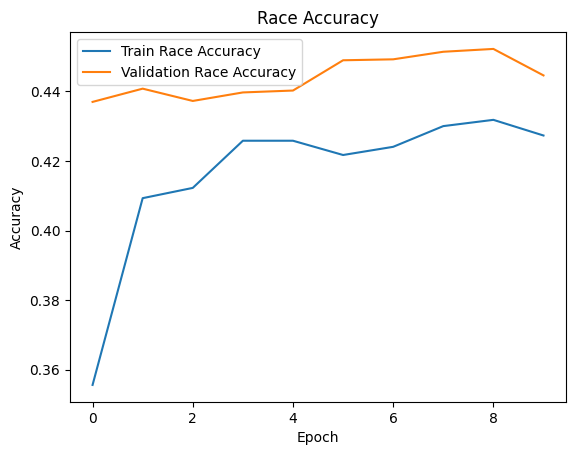

In [45]:
# Plot Race Accuracy
plt.plot(history.history['race_accuracy'], label='Train Race Accuracy')
plt.plot(history.history['val_race_accuracy'], label='Validation Race Accuracy')
plt.title('Race Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

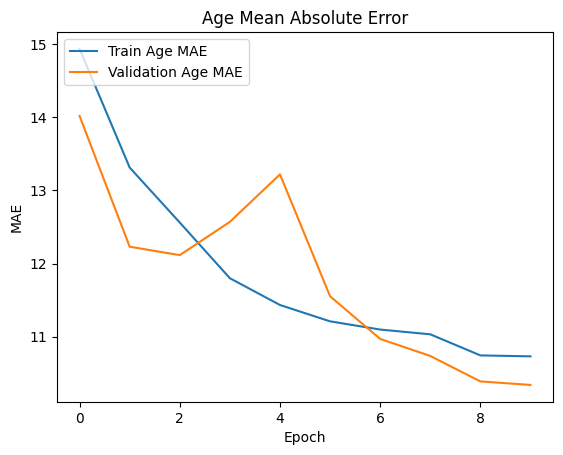

In [46]:
# Plot Age MAE
plt.plot(history.history['age_mae'], label='Train Age MAE')
plt.plot(history.history['val_age_mae'], label='Validation Age MAE')
plt.title('Age Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

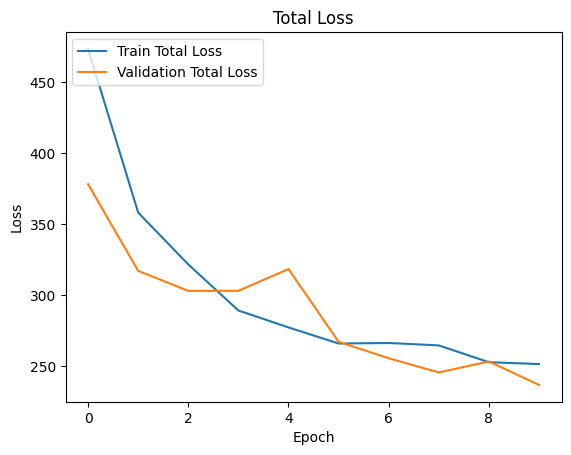

In [47]:
# Plot Total Loss
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Validation Total Loss')
plt.title('Total Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()